In [41]:
import os
print("Current working directory:", os.getcwd())
import importlib
import sys
sys.path.append('/data')
print(os.listdir('/data'))
import torch
import torch.nn as nn
# LSTM 
from model.lstm import LSTM
# GRU 
from model.gru import GRUModel
# Neural Network 
from model.neural import NeuralODE
# Transformer 
from transformer import TransformerModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split  # 从 scikit-learn 的 model_selection 模块导入 split 方法用于分割训练集和测试集
from sklearn.preprocessing import StandardScaler  
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report

import torch.optim as optim
from sklearn.metrics import roc_curve, auc

Current working directory: /
['gzh', 'run.ipynb', 'Untitled-1.py', 'bert-base-uncased', 'All(1).xlsx', 'data.csv', 'run_.py', 'model', 'run.py', 'transformer.py', '__pycache__', 'run_weida.ipynb', 'TrafficLabelling']


[[ 1.00000000e+00 -9.51999207e+02  1.63980881e+02 ...  1.70204810e+03
   2.20064819e+03  2.57268018e+03]
 [ 1.00000000e+00  2.34012375e+02 -2.14050640e+01 ...  3.87370850e+02
   9.42485413e+02  1.74413525e+03]
 [ 1.00000000e+00 -4.02055206e+02 -2.33310974e+02 ... -1.06804939e+02
  -1.00123848e+02  5.98292240e+01]
 ...
 [ 1.00000000e+00 -3.54019897e+02  5.29676758e+02 ...  2.96929260e+02
   5.66300476e+02  6.93430298e+02]
 [ 1.00000000e+00  1.69617661e+02 -3.17932251e+02 ... -3.45730469e+02
  -1.03475870e+01  6.33245300e+02]
 [ 1.00000000e+00 -1.95822250e+02 -1.40486282e+02 ...  5.03955658e+02
   3.67848328e+02 -1.95307693e+02]]


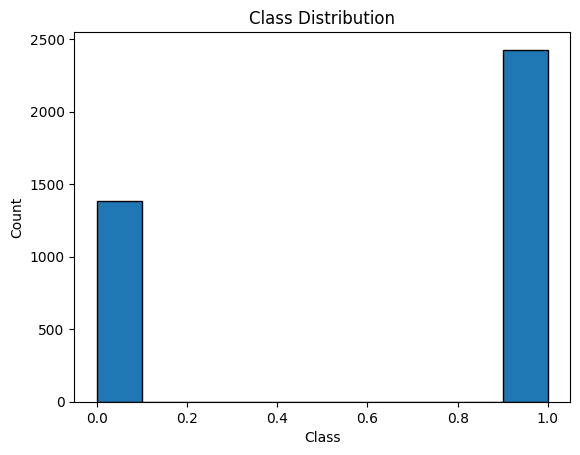

[[-951.999207  163.980881 1215.220215 ... 1702.048096 2200.648193
  2572.680176]
 [ 234.012375  -21.405064  124.714081 ...  387.37085   942.485413
  1744.135254]
 [-402.055206 -233.310974  -46.596706 ... -106.804939 -100.123848
    59.829224]
 ...
 [-354.019897  529.676758 1538.847168 ...  296.92926   566.300476
   693.430298]
 [ 169.617661 -317.932251 -572.153625 ... -345.730469  -10.347587
   633.2453  ]
 [-195.82225  -140.486282  -57.452263 ...  503.955658  367.848328
  -195.307693]]
[1. 1. 1. ... 1. 1. 1.]


In [42]:
data = pd.read_csv('/data/data.csv').values
data =  np.random.permutation(data)
print(data)
plt.hist(data[:,0], edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()
X = data[:,1:]
Y= data[:,0]
print(X)
print(Y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

/tmp/ipykernel_234049/1169129972.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_234049/1169129972.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_234049/1169129972.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_234049/1169129972.py:12: UserWarning: To copy construct from a tensor, it is recommended to use so

In [27]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TransformerModel, self).__init__()
        # 定义 Transformer 编码器，并指定输入维数和头数
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=1)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        # 定义全连接层，将 Transformer 编码器的输出映射到分类空间
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        # 在序列的第2个维度（也就是时间步或帧）上添加一维以适应 Transformer 的输入格式
        x = x.unsqueeze(1)
        # 将输入数据流经 Transformer 编码器进行特征提取
        x = self.encoder(x)
        # 通过压缩第2个维度将编码器的输出恢复到原来的形状
        x = x.squeeze(1)
        # 将编码器的输出传入全连接层，获得最终的输出结果
        x = self.fc(x)
        return x


In [19]:
print("创建模型")
# 初始化 Transformer 模型

model = TransformerModel(input_size=1015, num_classes=2)

创建模型


In [1]:
# 定义损失函数和优化器

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# 存储训练过程中的损失值和召回率
train_losses = []
recall_scores = []

accuracy_scores = []  # 初始化accuracy_scores
precision_scores = []
f1_scores = []
mse_scores = []

print("训练模型")
num_epochs = 1000
for epoch in range(num_epochs):
    # 前向传播计算输出结果
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # 反向传播，更新梯度并优化模型参数
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 记录损失值
    train_losses.append(loss.item())

    # 每10个epoch计算召回率
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            _, predicted = torch.max(outputs, 1)
            # 计算各类指标
            accuracy = accuracy_score(y_train, predicted)
            recall = recall_score(y_train, predicted, average='macro')  # 宏平均
            precision = precision_score(y_train, predicted, average='macro')  # 宏平均
            f1 = f1_score(y_train, predicted, average='macro')  # 宏平均
            mse = mean_squared_error(y_train, predicted)  # MSE

            # 记录每个指标的值
            accuracy_scores.append(accuracy)
            recall_scores.append(recall)
            precision_scores.append(precision)
            f1_scores.append(f1)
            mse_scores.append(mse)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, '
              f'Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, MSE: {mse:.4f}')
print("测试模型")
# 测试模型的评分


NameError: name 'nn' is not defined

In [40]:
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    # 计算测试集的各类评估指标
    print(predicted)
    accuracy = accuracy_score(y_test, predicted)
    recall = recall_score(y_test, predicted, average='macro')  # 宏平均
    precision = precision_score(y_test, predicted, average='macro')  # 宏平均
    f1 = f1_score(y_test, predicted, average='macro')  # 宏平均
    mse = mean_squared_error(y_test, predicted)  # MSE

    print(f'Test Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, '
          f'F1 Score: {f1:.4f}, MSE: {mse:.4f}')

    # 输出分类报告，查看每个类别的性能
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))

    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制准确率曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(10, num_epochs + 1, 10), accuracy_scores, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制召回率曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(10, num_epochs + 1, 10), recall_scores, label='Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制精确率曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(10, num_epochs + 1, 10), precision_scores, label='Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制 F1 分数曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(10, num_epochs + 1, 10), f1_scores, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制 MSE 曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(10, num_epochs + 1, 10), mse_scores, label='Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error Curve')
    plt.legend()
    plt.grid()
    plt.show()

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,

NameError: name 'num_epochs' is not defined

<Figure size 1000x600 with 0 Axes>

In [39]:
train_losses

NameError: name 'train_losses' is not defined

In [35]:
model = torch.load('model.pth')
# 设置模型为评估模式
model.eval()

outputs = model(X_test)
#print(X_test)
_, predicted = torch.max(outputs.data, 1)


In [36]:
y_pre=model(X_train)
X_train =X_train .detach().numpy()
y_train = y_train.detach().numpy().reshape(len(y_train),-1)
_, y_pre = torch.max(y_pre.data, 1)
y_pre= y_pre.detach().numpy().reshape(len(y_pre),-1)
#print(y_pre)

train = np.hstack((y_train , y_pre))
print(train)
train= np.hstack((train,X_train))
print(train)
np.savetxt('./train.csv',train,delimiter=',')

same_count = np.sum(y_pre == y_pre)
print(f"两个数组中相同的元素个数: {same_count}")

count_1 = np.sum(y_train == 1)  # 统计 Y_test 中值为 1 的数量
correct_1 = np.sum((y_train == 1) & (y_pre == 1))  # 统计预测正确的数量
probability_1 = correct_1 / count_1 if count_1 > 0 else 0  # 成功概率

# Y_test 中值为 0 的个数和预测成功的概率
count_0 = np.sum(y_train == 0)  # 统计 Y_test 中值为 0 的数量
correct_0 = np.sum((y_train == 0) & (y_pre == 0))  # 统计预测正确的数量
probability_0 = correct_0 / count_0 if count_0 > 0 else 0  # 成功概率
# 输出结果
print(f"Y_test 中值为 1 的个数: {count_1}")
print(f"预测成功的概率 (值为 1): {probability_1:.4f}")
print(f"Y_test 中值为 0 的个数: {count_0}")
print(f"预测成功的概率 (值为 0): {probability_0:.4f}")

[[0 0]
 [1 1]
 [0 0]
 ...
 [1 1]
 [1 1]
 [0 0]]
[[ 0.00000000e+00  0.00000000e+00  4.87183723e+01 ...  6.88594103e+00
  -2.52977772e+01 -9.41139526e+01]
 [ 1.00000000e+00  1.00000000e+00 -7.74501282e+02 ...  7.11680908e+02
   1.09216553e+03  1.44794666e+03]
 [ 0.00000000e+00  0.00000000e+00 -1.21640656e+02 ...  2.51375565e+02
   1.91022446e+02  4.50003853e+01]
 ...
 [ 1.00000000e+00  1.00000000e+00 -2.78263702e+02 ... -6.58242645e+01
  -1.76734295e+01 -8.27314072e+01]
 [ 1.00000000e+00  1.00000000e+00 -2.48549271e+02 ...  9.08679932e+02
   9.98085693e+02  8.37824036e+02]
 [ 0.00000000e+00  0.00000000e+00  7.16342316e+01 ...  7.39940977e+00
   7.93778992e+00  8.06886196e+00]]
两个数组中相同的元素个数: 3051
Y_test 中值为 1 的个数: 1919
预测成功的概率 (值为 1): 1.0000
Y_test 中值为 0 的个数: 1132
预测成功的概率 (值为 0): 1.0000


In [38]:

Y_test=y_test.detach().numpy().reshape(len(y_test),-1)

predict_1 = predicted.detach().numpy().reshape(len(predicted),-1)
print(predict_1)

same_count = np.sum(Y_test == predict_1)
print(f"两个数组中相同的元素个数: {same_count}")

count_1 = np.sum(Y_test == 1)  # 统计 Y_test 中值为 1 的数量
correct_1 = np.sum((Y_test == 1) & (predict_1 == 1))  # 统计预测正确的数量
probability_1 = correct_1 / count_1 if count_1 > 0 else 0  # 成功概率

# Y_test 中值为 0 的个数和预测成功的概率
count_0 = np.sum(Y_test == 0)  # 统计 Y_test 中值为 0 的数量
correct_0 = np.sum((Y_test == 0) & (predict_1 == 0))  # 统计预测正确的数量
probability_0 = correct_0 / count_0 if count_0 > 0 else 0  # 成功概率
# 输出结果
print(f"Y_test 中值为 1 的个数: {count_1}")
print(f"预测成功的概率 (值为 1): {probability_1:.4f}")
print(f"Y_test 中值为 0 的个数: {count_0}")
print(f"预测成功的概率 (值为 0): {probability_0:.4f}")

train = np.hstack((Y_test , predict_1))
print(train)
X=X_test.detach().numpy().reshape(len(predict_1),-1)
train= np.hstack((train,X))
print(train)
np.savetxt('./test.csv',train,delimiter=',')


print(train)


[[1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
